# Minplus algebra experiment

This code attempts to learn the 32D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()

    # Plot cross sections of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()




def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 32

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 10       # beta of softplus
hidden = 128     # number of hidden units
layers = 20      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(Iterations):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 1857.390380859375
iteration 0 loss 901662.3125


iteration 5000 loss 14.754596710205078


iteration 10000 loss 11.56975269317627


iteration 15000 loss 6.01247501373291


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 0.12435106933116913


iteration 25000 loss 0.09463514387607574


iteration 30000 loss 0.06220601499080658


iteration 35000 loss 0.04650566726922989


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 0.037830714136362076


iteration 45000 loss 0.03485776111483574


iteration 50000 loss 0.031012844294309616


iteration 55000 loss 0.027892565354704857


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.025443194434046745


iteration 65000 loss 0.02492537721991539


iteration 70000 loss 0.024156732484698296


iteration 75000 loss 0.023428643122315407


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.02273493818938732


iteration 85000 loss 0.02266102097928524


iteration 90000 loss 0.02258511818945408


iteration 95000 loss 0.022509753704071045


Learning rate decreased to 1.0000000000000005e-09 at iteration 100000
iteration 100000 loss 0.022434884682297707


iteration 105000 loss 0.022429518401622772


iteration 110000 loss 0.022424159571528435


iteration 115000 loss 0.022418836131691933


Learning rate decreased to 1.0000000000000006e-10 at iteration 120000
iteration 120000 loss 0.022413522005081177


iteration 125000 loss 0.022413475438952446


iteration 130000 loss 0.022413432598114014


iteration 135000 loss 0.022413384169340134


Learning rate decreased to 1.0000000000000006e-11 at iteration 140000
iteration 140000 loss 0.022413335740566254


iteration 145000 loss 0.022413332015275955


iteration 150000 loss 0.022413332015275955


iteration 155000 loss 0.022413332015275955


Learning rate decreased to 1.0000000000000006e-12 at iteration 160000
iteration 160000 loss 0.022413332015275955


iteration 165000 loss 0.022413330152630806


iteration 170000 loss 0.022413330152630806


iteration 175000 loss 0.022413328289985657


Learning rate decreased to 1.0000000000000007e-13 at iteration 180000
iteration 180000 loss 0.022413330152630806


iteration 185000 loss 0.022413330152630806


iteration 190000 loss 0.022413330152630806


iteration 195000 loss 0.022413330152630806


Learning rate decreased to 1.0000000000000008e-14 at iteration 200000
iteration 200000 loss 0.022413330152630806


iteration 205000 loss 0.022413330152630806


iteration 210000 loss 0.022413330152630806


iteration 215000 loss 0.022413330152630806


Learning rate decreased to 1.0000000000000009e-15 at iteration 220000
iteration 220000 loss 0.022413330152630806


iteration 225000 loss 0.022413330152630806


iteration 230000 loss 0.022413330152630806


iteration 235000 loss 0.022413330152630806


Learning rate decreased to 1.000000000000001e-16 at iteration 240000
iteration 240000 loss 0.022413330152630806


iteration 245000 loss 0.022413330152630806


iteration 250000 loss 0.022413330152630806


iteration 255000 loss 0.022413330152630806


Learning rate decreased to 1.000000000000001e-17 at iteration 260000
iteration 260000 loss 0.022413330152630806


iteration 265000 loss 0.022413330152630806


iteration 270000 loss 0.022413330152630806


iteration 275000 loss 0.022413330152630806


Learning rate decreased to 1.000000000000001e-18 at iteration 280000
iteration 280000 loss 0.022413330152630806


iteration 285000 loss 0.022413330152630806


iteration 290000 loss 0.022413330152630806


iteration 295000 loss 0.022413330152630806


Learning rate decreased to 1.000000000000001e-19 at iteration 300000
iteration 300000 loss 0.022413330152630806


iteration 305000 loss 0.022413330152630806


iteration 310000 loss 0.022413330152630806


iteration 315000 loss 0.022413330152630806


Learning rate decreased to 1.0000000000000011e-20 at iteration 320000
iteration 320000 loss 0.022413330152630806


iteration 325000 loss 0.022413330152630806


iteration 330000 loss 0.022413330152630806


iteration 335000 loss 0.022413330152630806


Learning rate decreased to 1.0000000000000012e-21 at iteration 340000
iteration 340000 loss 0.022413330152630806


iteration 345000 loss 0.022413330152630806


iteration 350000 loss 0.022413330152630806


iteration 355000 loss 0.022413330152630806


Learning rate decreased to 1.0000000000000012e-22 at iteration 360000
iteration 360000 loss 0.022413330152630806


iteration 365000 loss 0.022413330152630806


iteration 370000 loss 0.022413330152630806


iteration 375000 loss 0.022413330152630806


Learning rate decreased to 1.0000000000000013e-23 at iteration 380000
iteration 380000 loss 0.022413330152630806


iteration 385000 loss 0.022413330152630806


iteration 390000 loss 0.022413330152630806


iteration 395000 loss 0.022413330152630806


Learning rate decreased to 1.0000000000000014e-24 at iteration 400000
iteration 400000 loss 0.022413330152630806


iteration 405000 loss 0.022413330152630806


iteration 410000 loss 0.022413330152630806


iteration 415000 loss 0.022413330152630806


Learning rate decreased to 1.0000000000000014e-25 at iteration 420000
iteration 420000 loss 0.022413330152630806


iteration 425000 loss 0.022413330152630806


iteration 430000 loss 0.022413330152630806


iteration 435000 loss 0.022413330152630806


Learning rate decreased to 1.0000000000000015e-26 at iteration 440000
iteration 440000 loss 0.022413330152630806


iteration 445000 loss 0.022413330152630806


iteration 450000 loss 0.022413330152630806


iteration 455000 loss 0.022413330152630806


Learning rate decreased to 1.0000000000000015e-27 at iteration 460000
iteration 460000 loss 0.022413330152630806


iteration 465000 loss 0.022413330152630806


iteration 470000 loss 0.022413330152630806


iteration 475000 loss 0.022413330152630806


Learning rate decreased to 1.0000000000000015e-28 at iteration 480000
iteration 480000 loss 0.022413330152630806


iteration 485000 loss 0.022413330152630806


iteration 490000 loss 0.022413330152630806


iteration 495000 loss 0.022413330152630806


L2 loss -- Plot

loss -34.825111389160156


loss -195.3001251220703


loss -295.44903564453125


loss -380.9803466796875


loss -457.5013427734375


loss -523.6748046875


loss -577.9088134765625


loss -619.95458984375


loss -651.5621948242188


loss -675.1079711914062


loss -692.1690673828125


loss -703.9625244140625


loss -711.6329345703125


loss -716.2816772460938


loss -718.8887939453125


loss -720.232421875


loss -720.862548828125


loss -721.1256713867188


loss -721.219482421875


loss -721.2462768554688


loss -721.2518310546875


loss -721.2526245117188


loss -721.252685546875


loss -721.252685546875


loss -721.252685546875


loss -721.252685546875


loss -721.252685546875


loss -721.252685546875


loss -721.252685546875


loss -721.252685546875


loss -721.252685546875


loss -721.252685546875


loss -721.252685546875


loss -721.252685546875


loss -721.252685546875


loss -721.252685546875


loss -721.252685546875


loss -721.252685546875


loss -721.252685546875


loss -721.252685546875


final mse:  3.764324685295861e-10
max, min: 5.9399004 -6.7416058
loss -34.825111389160156


loss -199.22457885742188


loss -299.3556213378906


loss -385.3056640625


loss -464.3004150390625


loss -536.0458984375


loss -599.0849609375


loss -651.5936279296875


loss -693.9703369140625


loss -728.031494140625


loss -754.330078125


loss -773.5990600585938


loss -786.96728515625


loss -795.76416015625


loss -801.2501220703125


loss -804.44482421875


loss -806.14013671875


loss -806.939208984375


loss -807.2642822265625


loss -807.3740234375


loss -807.403076171875


loss -807.40869140625


loss -807.409423828125


loss -807.409423828125


loss -807.409423828125


loss -807.409423828125


loss -807.4094848632812


loss -807.409423828125


loss -807.409423828125


loss -807.409423828125


loss -807.409423828125


loss -807.409423828125


loss -807.409423828125


loss -807.409423828125


loss -807.409423828125


loss -807.409423828125


loss -807.409423828125


loss -807.409423828125


loss -807.409423828125


loss -807.409423828125


final mse:  5.87840665033923e-10
max, min: 6.8071938 -7.2713666


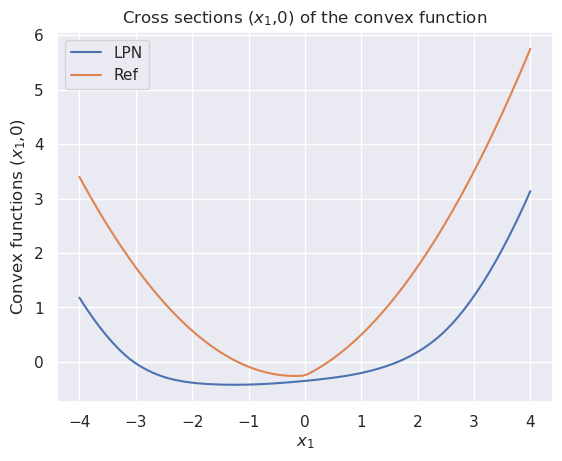

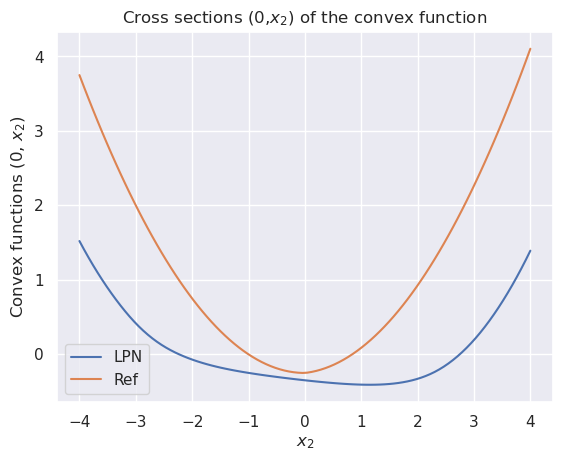

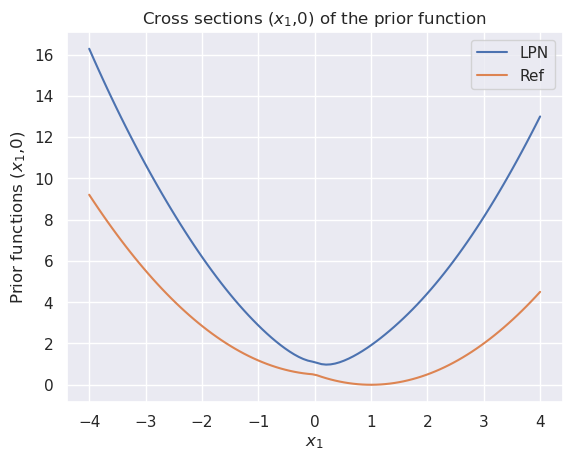

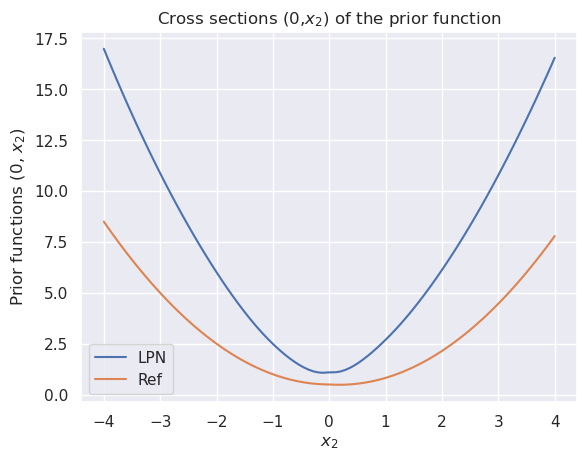

In [7]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")

# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(Iterations):
    if (i % 20000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")

Generated G samples: G_samples_tensor shape torch.Size([40000, 1])

--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 1641.153076171875
iteration 0 loss 191696.15625


iteration 5000 loss 4.149205207824707


iteration 10000 loss 2.081822395324707


iteration 15000 loss 1.251312494277954


Learning rate decreased to 1e-05 at iteration 20000
iteration 20000 loss 0.20247556269168854


iteration 25000 loss 0.16596102714538574


iteration 30000 loss 0.11337198317050934


iteration 35000 loss 0.08890921622514725


Learning rate decreased to 1.0000000000000002e-06 at iteration 40000
iteration 40000 loss 0.0731487050652504


iteration 45000 loss 0.06868544220924377


iteration 50000 loss 0.06262285262346268


iteration 55000 loss 0.057615719735622406


Learning rate decreased to 1.0000000000000002e-07 at iteration 60000
iteration 60000 loss 0.05326543003320694


iteration 65000 loss 0.05264952406287193


iteration 70000 loss 0.051691051572561264


iteration 75000 loss 0.05076015368103981


Learning rate decreased to 1.0000000000000004e-08 at iteration 80000
iteration 80000 loss 0.04986248537898064


iteration 85000 loss 0.04976843297481537


iteration 90000 loss 0.04967264458537102


iteration 95000 loss 0.04957737773656845


Learning rate decreased to 1.0000000000000005e-09 at iteration 100000
iteration 100000 loss 0.04948261007666588


iteration 105000 loss 0.04947642982006073


iteration 110000 loss 0.049470316618680954


iteration 115000 loss 0.049464162439107895


Learning rate decreased to 1.0000000000000006e-10 at iteration 120000
iteration 120000 loss 0.04945806413888931


iteration 125000 loss 0.049458011984825134


iteration 130000 loss 0.04945795610547066


iteration 135000 loss 0.04945790022611618


Learning rate decreased to 1.0000000000000006e-11 at iteration 140000
iteration 140000 loss 0.04945787042379379


iteration 145000 loss 0.0494578592479229


iteration 150000 loss 0.0494578592479229


iteration 155000 loss 0.0494578592479229


Learning rate decreased to 1.0000000000000006e-12 at iteration 160000
iteration 160000 loss 0.0494578592479229


iteration 165000 loss 0.0494578592479229


iteration 170000 loss 0.0494578555226326


iteration 175000 loss 0.0494578555226326


Learning rate decreased to 1.0000000000000007e-13 at iteration 180000
iteration 180000 loss 0.0494578592479229


iteration 185000 loss 0.0494578592479229


iteration 190000 loss 0.0494578592479229


iteration 195000 loss 0.0494578592479229


Learning rate decreased to 1.0000000000000008e-14 at iteration 200000
iteration 200000 loss 0.0494578555226326


iteration 205000 loss 0.0494578555226326


iteration 210000 loss 0.0494578555226326


iteration 215000 loss 0.0494578555226326


Learning rate decreased to 1.0000000000000009e-15 at iteration 220000
iteration 220000 loss 0.0494578555226326


iteration 225000 loss 0.0494578555226326


iteration 230000 loss 0.0494578555226326


iteration 235000 loss 0.0494578555226326


Learning rate decreased to 1.000000000000001e-16 at iteration 240000
iteration 240000 loss 0.0494578555226326


iteration 245000 loss 0.0494578555226326


iteration 250000 loss 0.0494578555226326


iteration 255000 loss 0.0494578555226326


Learning rate decreased to 1.000000000000001e-17 at iteration 260000
iteration 260000 loss 0.0494578555226326


iteration 265000 loss 0.0494578555226326


iteration 270000 loss 0.0494578555226326


iteration 275000 loss 0.0494578555226326


Learning rate decreased to 1.000000000000001e-18 at iteration 280000
iteration 280000 loss 0.0494578555226326


iteration 285000 loss 0.0494578555226326


iteration 290000 loss 0.0494578555226326


iteration 295000 loss 0.0494578555226326


Learning rate decreased to 1.000000000000001e-19 at iteration 300000
iteration 300000 loss 0.0494578555226326


iteration 305000 loss 0.0494578555226326


iteration 310000 loss 0.0494578555226326


iteration 315000 loss 0.0494578555226326


Learning rate decreased to 1.0000000000000011e-20 at iteration 320000
iteration 320000 loss 0.0494578555226326


iteration 325000 loss 0.0494578555226326


iteration 330000 loss 0.0494578555226326


iteration 335000 loss 0.0494578555226326


Learning rate decreased to 1.0000000000000012e-21 at iteration 340000
iteration 340000 loss 0.0494578555226326


iteration 345000 loss 0.0494578555226326


iteration 350000 loss 0.0494578555226326


iteration 355000 loss 0.0494578555226326


Learning rate decreased to 1.0000000000000012e-22 at iteration 360000
iteration 360000 loss 0.0494578555226326


iteration 365000 loss 0.0494578555226326


iteration 370000 loss 0.0494578555226326


iteration 375000 loss 0.0494578555226326


Learning rate decreased to 1.0000000000000013e-23 at iteration 380000
iteration 380000 loss 0.0494578555226326


iteration 385000 loss 0.0494578555226326


iteration 390000 loss 0.0494578555226326


iteration 395000 loss 0.0494578555226326


Learning rate decreased to 1.0000000000000014e-24 at iteration 400000
iteration 400000 loss 0.0494578555226326


iteration 405000 loss 0.0494578555226326


iteration 410000 loss 0.0494578555226326


iteration 415000 loss 0.0494578555226326


Learning rate decreased to 1.0000000000000014e-25 at iteration 420000
iteration 420000 loss 0.0494578555226326


iteration 425000 loss 0.0494578555226326


iteration 430000 loss 0.0494578555226326


iteration 435000 loss 0.0494578555226326


Learning rate decreased to 1.0000000000000015e-26 at iteration 440000
iteration 440000 loss 0.0494578555226326


iteration 445000 loss 0.0494578555226326


iteration 450000 loss 0.0494578555226326


iteration 455000 loss 0.0494578555226326


Learning rate decreased to 1.0000000000000015e-27 at iteration 460000
iteration 460000 loss 0.0494578555226326


iteration 465000 loss 0.0494578555226326


iteration 470000 loss 0.0494578555226326


iteration 475000 loss 0.0494578555226326


Learning rate decreased to 1.0000000000000015e-28 at iteration 480000
iteration 480000 loss 0.0494578555226326


iteration 485000 loss 0.0494578555226326


iteration 490000 loss 0.0494578555226326


iteration 495000 loss 0.0494578555226326


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


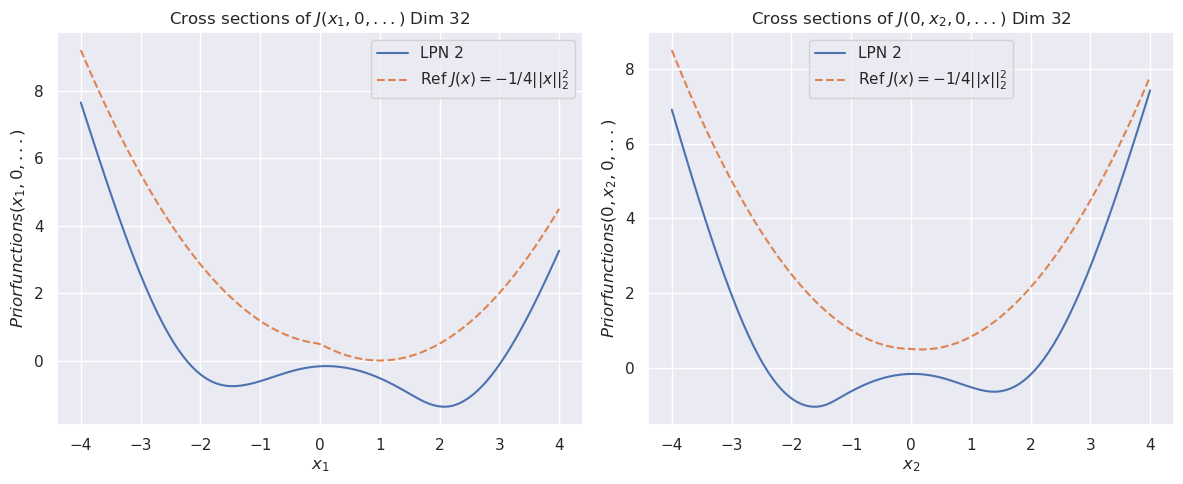

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2)